Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

After you finish the assignment and fill in your code and response where needed (all cells should have been run), save the notebook as a PDF using the `jupyter nbconvert --to pdf HW11.ipynb` command (via a notebook code cell or the command line directly) and submit the PDF to Gradescope under the PDF submission item. If you cannot get this to work locally, you can upload the notebook to Google Colab and create the PDF there. You can find the notebook containing the instruction for this on Canvas.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW11.ipynb`

In [1]:
from typing import Union
from tqdm import tqdm
import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader

from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import InterpolationMode
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18

from HW11_utils import Tracker

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'
print(f'Device is {Device}')

Device is cuda


# Contrastive loss functions (40)

A common loss function for contrastive learning is the NT-Xent loss introduced in [SimCLR](https://arxiv.org/pdf/2002.05709), which tries to maximize the cosine similarity between the features of the augmented data pairs that come from the same sample. The loss is a normalized temperature-scaled cross-entropy, i.e. NT-Xent, and is defined as follows for each pair:
$$
\ell_{i,j} = - \log \frac{\exp(\text{sim}(\mathbf{z}_i, \mathbf{z}_j) / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(\mathbf{z}_i, \mathbf{z}_k) / \tau)}
$$
The final loss is the average of the loss _over the positive pairs_, as you can also see in the pseudo-code in the paper. You have to implement this loss function as a module, and use this layer in your contrastive pre-training. Make sure the devices of the tensors are consistent.

The next loss that you are going to implement is the the [Barlow Twins Loss](https://arxiv.org/pdf/2103.03230) with the aim to reduce feature redundancy. With the SimCLR loss funcion, the model could optimize the loss by simply filling the whole feature vector with just one feature that is the same across all feature dimensions, and that would hypothetically minimize the loss function. However, we would want a rich representation rather than one feature or a redundant feature vector with a lot of repetitive features. The Barlow Twins loss works with the correlation of the features with each other in a batch to make sure that the features are not redundant. For your implementation, you can refer to the pseudo-code in the paper.

NOTE: You can and should implement these loss functions without any `for` loops. Each for loop will have a penalty of -5. You may find `torch.diag` and `torch.eye` helpful. For numerical stability, we suggest using `F.log_softmax` or `F.cross_entropy` for `NT_Xent` implementation.

In [2]:
# AUTOGRADED

class NT_Xent(nn.Module):

    def __init__(
            self,
            temp: float = 0.5,
            ):
        super().__init__()
        self.temp = temp

    def forward(
            self,
            z1: torch.FloatTensor, # (N, D)
            z2: torch.FloatTensor, # (N, D)
            ):
        """
        z1 and z2 are two augmented batches of the same data.
        i.e. z1[i] and z2[i] are augmentations of the same image for each i.
        """
        n = z1.size(0)
        device = z1.device

        # cosine-similarity logits
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        z   = torch.cat([z1, z2], dim=0)                      # (2N, D)
        logits = (z @ z.T).div(self.temp)                     # (2N, 2N)

        # remove self-similarities from denominators
        mask = torch.eye(2 * n, dtype=torch.bool, device=device)
        logits = logits.masked_fill(mask, -1e9)

        # positives: sample i’s positive is i + N
        targets = (torch.arange(2 * n, device=device) + n) % (2 * n)

        # NT-Xent (mean over all 2N views == mean over N positive pairs)
        loss = F.cross_entropy(logits, targets, reduction='mean')
        return loss


class Barlow_Twins(nn.Module):

    def __init__(
            self,
            lambda_: float = 5e-3,
            ):
        super().__init__()
        self.lambda_ = lambda_

    def forward(
            self,
            z1: torch.FloatTensor, # (N, D)
            z2: torch.FloatTensor, # (N, D)
            ) -> torch.FloatTensor: # ()

        """
        ***Encourages the cross-correlation matrix between two views to be
        an identity matrix and the paper uses an identity-subtraction trick
        """
        N, D = z1.size()
        print(f"z1 size is {z1.size}")
        device = z1.device

        # Batch-norm (zero-mean, unit-std per feature)
        eps = 1e-12                                           # numerical safety
        z1_norm = (z1 - z1.mean(dim=0)) / (z1.std(dim=0) + eps)
        z2_norm = (z2 - z2.mean(dim=0)) / (z2.std(dim=0) + eps)

        # Cross-correlation matrix C = (D × D)
        c = (z1_norm.T @ z2_norm) / N                         # (D, D)

        # Loss = on-diag + lambda · off-diag
        #   on-diag term: make C_ii → 1
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()

        #   off-diag term: make C_ij → 0  (i ≠ j)
        off_diag = (c - torch.diag_embed(torch.diagonal(c))).pow(2).sum()

        loss = on_diag + self.lambda_ * off_diag
        return loss

In [3]:
from HW11_utils import Test_NT_Xent, Test_Barlow_Twins

Test_NT_Xent(NT_Xent)
Test_Barlow_Twins(Barlow_Twins)

===================== NT-Xent ====================
Test 1 passed!
--------------------------------------------------
Test 2 passed!
--------------------------------------------------
Test 3 passed!
--------------------------------------------------
Test 4 passed!
--------------------------------------------------
Test 5 passed!
--------------------------------------------------

z1 size is <built-in method size of Tensor object at 0x7e73bdff7a70>
z1 size is <built-in method size of Tensor object at 0x7e73bdff7a70>
z1 size is <built-in method size of Tensor object at 0x7e73bdff7bf0>
z1 size is <built-in method size of Tensor object at 0x7e73bdff7950>
z1 size is <built-in method size of Tensor object at 0x7e73bdff7950>
================== Barlow Twins ==================
Test 1 passed!
--------------------------------------------------
Test 2 passed!
--------------------------------------------------
Test 3 passed!
--------------------------------------------------
Test 4 passed!
---------

# Contrastive Pre-training with the CIFAR-10 dataset (60)

Now you can use your loss functions to pre-train a ResNet using contrastive self-supervised learning. First, download the dataset using the cell below.

In [4]:
train_dataset = CIFAR10(
    root = './CIFAR10',
    train = True,
    download = True,
    transform = T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])
    )

test_dataset = CIFAR10(
    root = './CIFAR10',
    train = False,
    download = True,
    transform = T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])
    )

print(f'train dataset size, {len(train_dataset)}')
print(f'test dataset size, {len(test_dataset)}')

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


train dataset size, 50000
test dataset size, 10000


## Augmentation (10)

Implement the augmentation class to be used for generating data pairs in contrastive learning.

In [5]:
class Augment:

    def __init__(
        self,
        img_size = 32,
        ):

        color_jitter = T.ColorJitter(
            brightness = 0.4,
            contrast = 0.4,
            saturation = 0.4,
            hue = 0.1,
            )
        """
        apply the following augmentations:
        Random resized crop to img_size
        Random horizontal flip with 50% probability
        Random color jitter with 80% probability
        Random grayscale with 20% probability
        """
        self.transform = T.Compose([
                        T.RandomResizedCrop(
                img_size,
                scale=(0.08, 1.0),
                interpolation=InterpolationMode.BILINEAR,
            ),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            # T.Normalize(mean=(0.5, 0.5, 0.5),
            #             std=(0.5, 0.5, 0.5)),   # ⇢ range ~[-1,1]
        ])


    def __call__(self, x):
        return self.transform(x)

## Training and evaluation functions (10)

Fill in `train_epoch` to complete the function for the case of contrastive learning.

In [6]:
@torch.enable_grad()
def train_epoch(
    model: nn.Module,
    trainloader: DataLoader,
    augment: Union[None, Augment],
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    device: str = Device,
    ):
    """
    A flexible function for a training epoch.
    Performs supervised learning if augment is None.
    Performs contrastive self-supervised learning if augment is not None.
    returns the losses for all training batches over the epoch as a list.
    """
    model.train().to(device)
    losses = []

    for x, y in trainloader:
        optimizer.zero_grad()

        if augment is None:
            # supervised learning
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
        else:
            # self-supervised contrastive learning
            # make two random views of the same batch
            x1 = augment(x)
            x2 = augment(x)

            # sanity-check aug
            for name, t in [('x1', x1), ('x2', x2)]:
                if not torch.isfinite(t).all():
                    raise RuntimeError(f'{name} has NaN/Inf *after augment*')

            # move to GPU
            x1 = x1.to(device, non_blocking=True)
            x2 = x2.to(device, non_blocking=True)

            # push both through the backbone + projector
            z1 = model(x1)
            z2 = model(x2)

            # NT-Xent / Barlow-Twins etc.
            # --- DEBUG ---------------------------------------------------------
            for name, t in [('z1', z1), ('z2', z2)]:
                if not torch.isfinite(t).all():
                    raise RuntimeError(f'{name} has NaN/Inf *after model*')

            # L2-normalise
            z1 = F.normalize(z1, dim=1, eps=1e-8)
            z2 = F.normalize(z2, dim=1, eps=1e-8)

            if not torch.isfinite(z1).all() or not torch.isfinite(z2).all():
                raise RuntimeError('NaN after normalisation')

            # NT-Xent
            loss = loss_fn(z1, z2)

            if not torch.isfinite(loss):
                raise RuntimeError('NaN in NT-Xent')

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        assert not torch.isnan(loss)
        assert not torch.isinf(loss)
        assert torch.isfinite(loss), "loss became inf / NaN"

    return losses


@torch.inference_mode()
def eval_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module = nn.CrossEntropyLoss(),
    device: str = Device,
    ):
    """
    Evaluates the model on the given dataloader.
    Only used for supervised learning of multi-class classification.
    """
    model.eval().to(device)

    loss_sum = 0.
    acc_sum = 0.
    N = 0

    for x, y in dataloader:

        x, y = x.to(device), y.to(device)
        N += len(x)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        assert not torch.isnan(loss)
        assert not torch.isinf(loss)

        loss_sum += loss.item()*len(x)
        acc_sum += (y_pred.argmax(-1) == y).float().sum().item()

    return loss_sum / N, acc_sum / N


def train(
    model: nn.Module,
    train_dataset: Dataset,
    test_dataset: Union[None, Dataset], # pass None for SSL
    augment: Union[None, Augment], # pass None for supervised learning
    loss_fn: nn.Module,
    device: str = Device,
    plot_freq: int = 1,

    optim_name: str = 'Adam', # from optim
    optim_config: dict = dict(),
    lr_scheduler_name: Union[str, None] = None, # from optim.lr_scheduler
    lr_scheduler_config: dict = dict(),

    n_epochs: int = 10,
    batch_size: int = 32,
    ):

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

    if augment is None: # supervised learning
        evalloader_traindata = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)

        if test_dataset is not None:
            evalloader_testdata = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

    optimizer: optim.Optimizer = optim.__getattribute__(optim_name)(model.parameters(), **optim_config)
    if lr_scheduler_name is not None:
        lr_scheduler: optim.lr_scheduler._LRScheduler = optim.lr_scheduler.__getattribute__(lr_scheduler_name)(optimizer, **lr_scheduler_config)

    epoch_pbar = tqdm(
        range(1, n_epochs+1),
        desc = 'epochs',
        unit = 'epoch',
        dynamic_ncols = True,
        leave = True,
        )

    tracker = Tracker(n_epochs = n_epochs, plot_freq = plot_freq)
    training_loss = None
    # evaluation metrics:
    train_loss, train_acc, test_loss, test_acc = 4*[None]

    for epoch in epoch_pbar:

        losses = train_epoch(
            model = model,
            trainloader = trainloader,
            augment = augment,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = device,
            )
        training_loss = np.mean(losses)

        if lr_scheduler_name == 'ReduceLROnPlateau':
            lr_scheduler.step(training_loss)
        elif lr_scheduler_name is not None:
            lr_scheduler.step()
        postfix_str = f'training loss: {training_loss:.4f}'

        # supervised learning evaluation
        if augment is None:

            train_loss, train_acc = eval_epoch(
                model = model,
                dataloader = evalloader_traindata,
                loss_fn = loss_fn,
                device = device,
                )
            postfix_str += f', train loss: {train_loss:.4f}, train acc: {train_acc:.4f}'

            if test_dataset is not None:
                test_loss, test_acc = eval_epoch(
                    model = model,
                    dataloader = evalloader_testdata,
                    loss_fn = loss_fn,
                    device = device,
                    )
                postfix_str += f', test loss: {test_loss:.4f}, test acc: {test_acc:.4f}'

        epoch_pbar.set_postfix_str(postfix_str)
        tracker.update(training_loss, train_loss, train_acc, test_loss, test_acc)

    return tracker

## Contrastive pre-training (10)

Now, we use the pre-defined `resnet18` with some modification for CIFAR10 dataset. Your task is to replace the projection head with a 2-layer feedforward network. This will be the $g$ in the SimCLR paper, and the $f$ is everything before that. After contrastive learning, we will discard $g$ and keep $f$ as a feature extractor. Then. we will train a linear classifier that uses the features from $f$. The tracker will only show one learning curve for the contrastive training loss in this section. The pretraining might take a while, and the rate of covergence is relatively slow compared to supervised learning.

In [7]:
# initialize a resnet18 model and modifying it for CIFAR10 according to SimCLR paper.
model = resnet18()
model.conv1 = nn.Conv2d(
    in_channels = 3,
    out_channels = 64,
    kernel_size = 3,
    stride = 1,
    padding = 1,
    bias = False,
    )
model.maxpool = nn.Identity()

The next cell contains the code for attaching a projection head $g$ and pretraining the model. To verify the effect of pretraining, skip this cell in your first try and complete the next sections (feature extraction and linear classification) using the model that has not been pretrained. Remember the results. Then try to complete the next sections after pretraining. If everything is correct, your classification result should improve by pretraining.

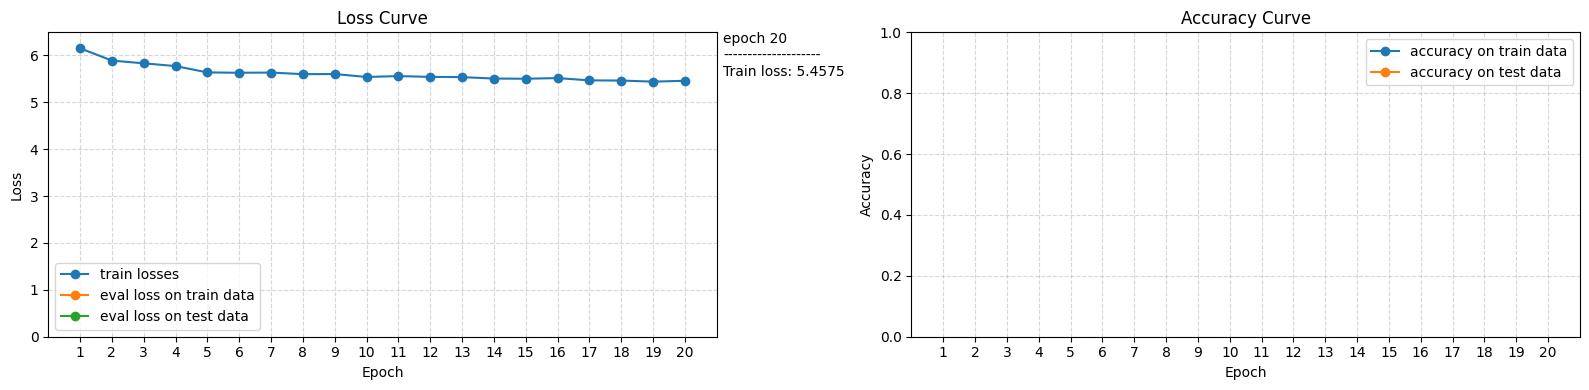

epochs: 100%|██████████| 20/20 [04:54<00:00, 14.73s/epoch, training loss: 5.4575]


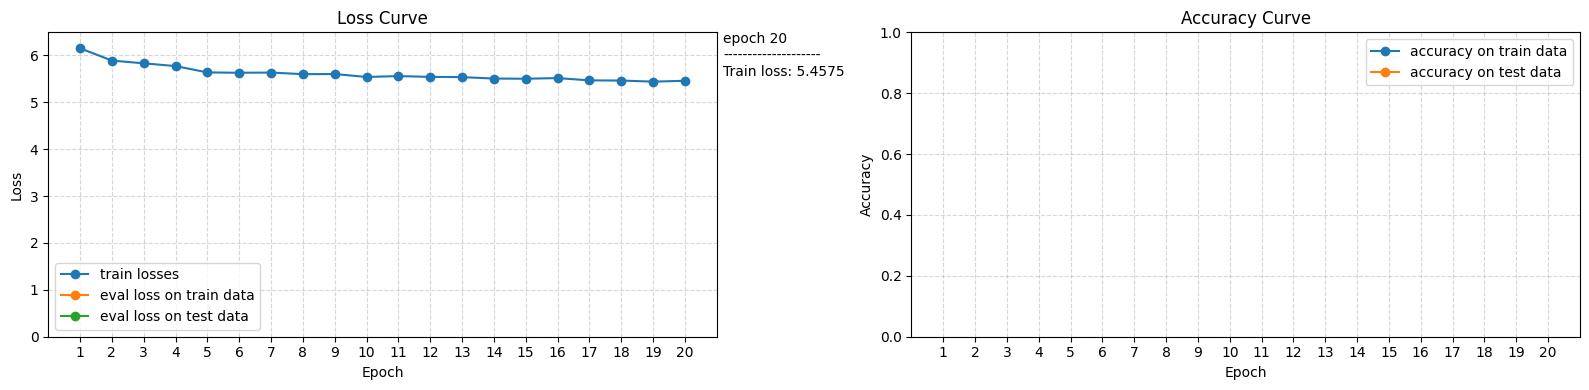

In [8]:
# Now replace the final layer of resnet with a 2-layer MLP using nn.Sequential(). This is the projection head g.
# The MLP has hidden size 2048 and output size 128. set bias=False, and use ReLU activation.
in_dim = model.fc.in_features          # 512 for ResNet-18
model.fc = nn.Sequential(
    nn.Linear(in_dim, 2048, bias=False),
    # nn.BatchNorm1d(2048),
    nn.ReLU(inplace=True),
    nn.Linear(2048, 128, bias=False),
    # nn.BatchNorm1d(128),
)


loss_fn = NT_Xent(temp = 0.5) # DO NOT CHANGE!
augment = Augment()

# SSL training configuration:
ssl_config = dict(
    optim_name = 'Adam',
    optim_config = dict(lr=1e-3),
    lr_scheduler_name = 'ReduceLROnPlateau',
    lr_scheduler_config = dict(factor=0.3, patience=2),
    n_epochs = 20,
    batch_size = 512, # Bigger batch sizes are better for contrastive learning
    )

# Run the SSL training
tracker = train(
    model = model,
    train_dataset = train_dataset,
    test_dataset = None,
    loss_fn = loss_fn,
    augment = augment,
    device = Device,
    plot_freq = 1,
    **ssl_config,
    )

## Feature extraction using the pre-trained feature extractor $f$ (10)

Discard the projection head by replacing it with an Identity module. Then, extract the features using the pre-trained model.

In [9]:
# discarding the projection head (g in SimCLR paper)
model.fc = nn.Identity()

# Passing the whole dataset through the feature extractor to get the feature representations
@torch.inference_mode()
def get_dataset_features(
    model: nn.Module,
    dataset: Dataset,
    batch_size: int = 256,
    device: str = Device,
    ):
    """
    A helper function to process the dataset for finetuning.
    """
    model.eval().to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    features = []
    labels = []

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        # extract the features and append them to the list
        features.append(model(x).detach().cpu())

        labels.append(y)

    features = torch.cat(features, dim=0).cpu()
    labels = torch.cat(labels, dim=0).cpu()

    return TensorDataset(features, labels)

# Get the featurized train and test dataset using the function above
finetune_train_dataset_features = get_dataset_features(
    model, train_dataset, batch_size=256, device=Device
)
finetune_test_dataset_features = get_dataset_features(
    model, test_dataset,  batch_size=256, device=Device
)

## Supervised learning with a linear classifier (10)

Define a linear classifier with no bias and train it on the featurized datasets. You should get around 60% test accuracy. For contrastive pre-training, a very large batch size and a very long training is usally needed for great results, which is not in the budget of a homework. However, you have learned the pipeline in this assignment!

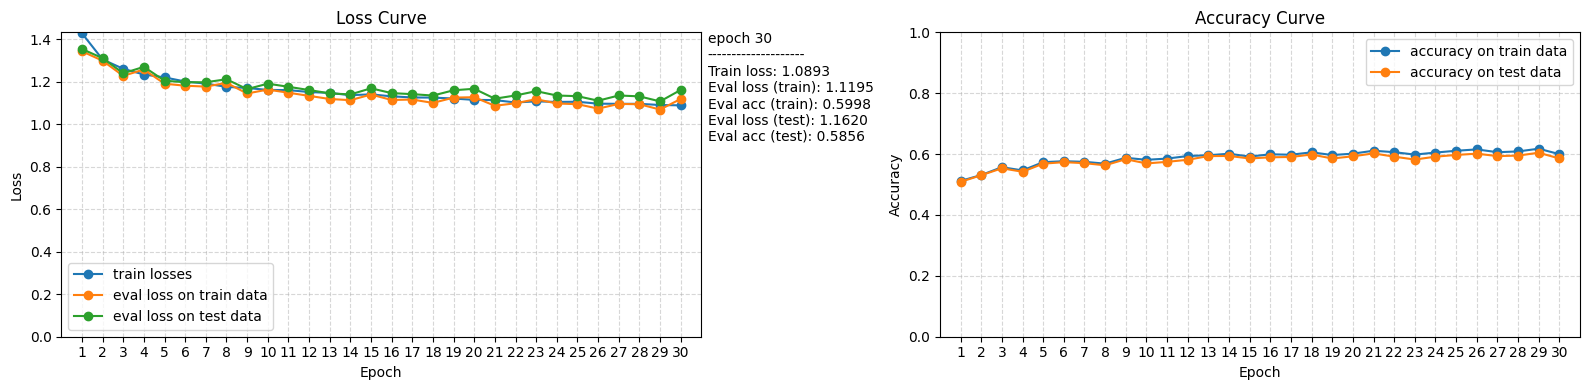

epochs: 100%|██████████| 30/30 [01:55<00:00,  3.86s/epoch, training loss: 1.0893, train loss: 1.1195, train acc: 0.5998, test loss: 1.1620, test acc: 0.5856]


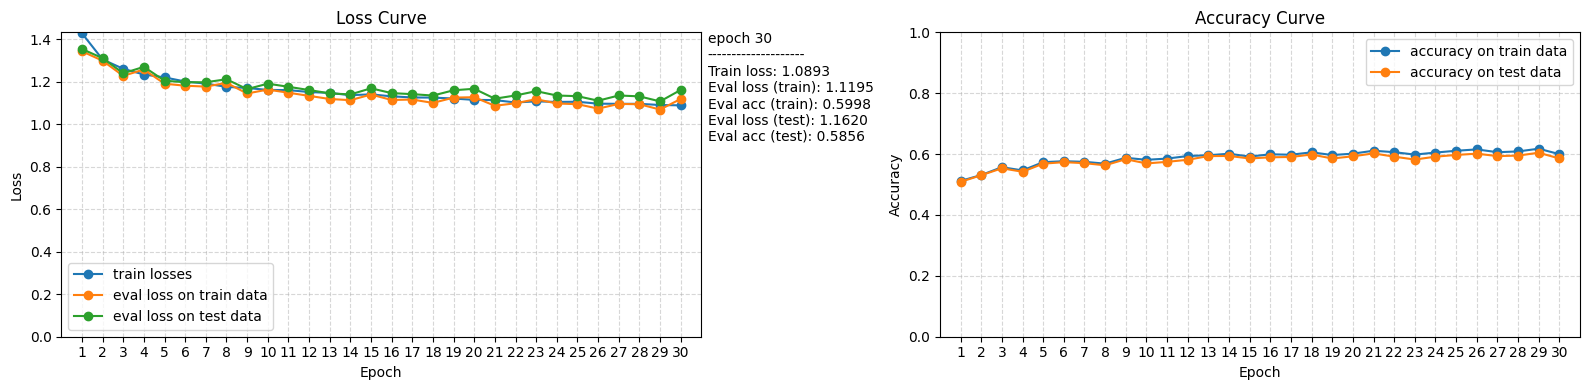

In [10]:
classifier = nn.Linear(512, 10, bias=False)

train_config = dict(
        optim_name = 'Adam',
        optim_config = dict(lr = 1e-3),
        lr_scheduler_name = 'ReduceLROnPlateau',
        lr_scheduler_config = dict(factor = 0.5, patience = 3),
        n_epochs = 30,
        batch_size = 64,
        )

# YOUR CODE
tracker = train(
    model = classifier,
    train_dataset = finetune_train_dataset_features,
    test_dataset  = finetune_test_dataset_features,
    augment = None,
    loss_fn = nn.CrossEntropyLoss(),
    device = Device,
    plot_freq = 1,
    **train_config,
    )

## Putting everything together as a full classifier (10)

In [ ]:
# create the final model by combining the feature extractor and the classifier.
# (one line of code should be enough)
model.fc = nn.Identity()
final_model = nn.Sequential(model, classifier)

# calculating the loss and accuracy on the train and test dataset

train_loss, train_acc = eval_epoch(
    model = final_model,
    dataloader = DataLoader(train_dataset, batch_size=64),
    device = Device,
    )

test_loss, test_acc = eval_epoch(
    model = final_model,
    dataloader = DataLoader(test_dataset, batch_size=64),
    device = Device,
    )

# You should get the same thing as the last epoch of your supervised learning!
print(f'train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
print(f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')

## Zip files for submission

In [ ]:
from HW11_utils import zip_files

submission_files = ['HW11.ipynb']
zip_files('HW11_submission.zip', submission_files)